# **Twitter Verileri Üzerinden Duygu Analizi**


In [1]:
#Gerekli kütüphanelerin dahil edilmesi
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy

# **Veri Keşfi ve Önişleme**

In [2]:
#Veri setinin yüklenmesi
file_path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1', header=None)

#Veri setinin küçültülmesi (örneklem)
df = df.sample(n=100000, random_state=42)

#Sütunları adlandırma (Veri setinde kolon adları yok)
df.columns = ['polarity', 'ids', 'date', 'flag', 'user', 'text']


In [3]:
#Veriler hakkında bilgi
print(df.info())
print(df.head())

#Sınıfların dağılımı
print(df['polarity'].value_counts())



<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 541200 to 429504
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  100000 non-null  int64 
 1   ids       100000 non-null  int64 
 2   date      100000 non-null  object
 3   flag      100000 non-null  object
 4   user      100000 non-null  object
 5   text      100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB
None
        polarity         ids                          date      flag  \
541200         0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750            0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711         0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055         0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995         0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaL

# **Veri Temizleme Adımları**

In [4]:
# 1. Text sütununu küçük harfe dönüştür
df['text'] = df['text'].str.lower()

# 2. URL'leri kaldır
df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", '', x, flags=re.MULTILINE))

# 3. Kullanıcı adlarını (@username) kaldır
df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', '', x))

# 4. Hashtag'leri kaldır
df['text'] = df['text'].apply(lambda x: re.sub(r'#\w+', '', x))

# 5. Noktalama işaretlerini kaldır
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# 6. Sayıları kaldır
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))

# 7. Fazla boşlukları tek bir boşluğa indir
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [5]:
# NLTK stop words'ü indir
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Stop-words temizliği
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# SpaCy modelini yükle
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Tokenizasyon ve lemmatizasyon fonksiyonu
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Text sütununda lemmatizasyon işlemi
df['text'] = df['text'].apply(lemmatize_text)

In [7]:
# İlk 5 satırı kontrol edelim
print(df.head())

# Sonucun kaydedilmesi
df.to_csv('/kaggle/working/cleaned_sentiment140.csv', index=False)

        polarity         ids                          date      flag  \
541200         0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750            0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711         0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055         0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995         0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609                                       ahhh hope ok  
750         sexygrneyes                                cool tweet app razr  
766711       sammydearr  know family drama lamehey next time u hang kim...  
285055      Lamb_Leanne  school email will not open geography stuff rev...  
705995      yogicerdito                               upper airway problem  


# Özellik Çıkarımı ve Temel Modelleme

Model Performansı:
Accuracy: 0.7558
Precision: 0.7473
Recall: 0.7734
F1-Score: 0.7601

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      9995
           1       0.75      0.77      0.76     10005

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



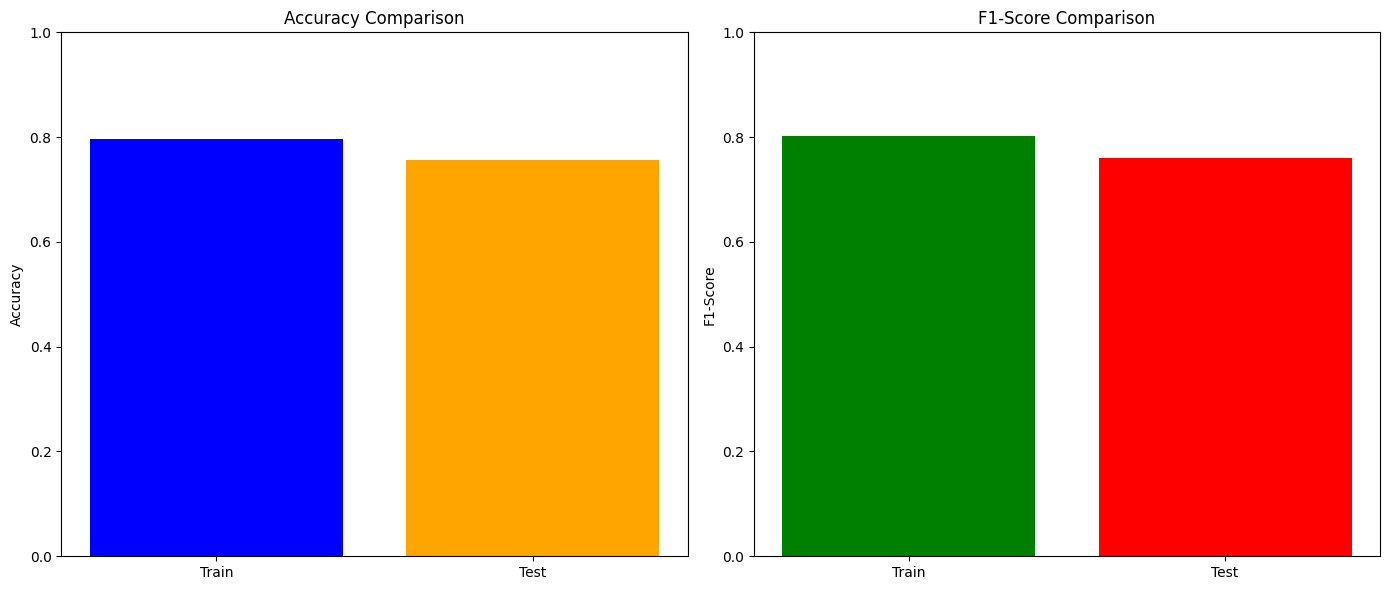

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Hedef ve bağımsız değişkenleri ayırma
X = df['text']
y = df['polarity']

# Sınıf etiketlerini binary olarak ayarlama (0: negatif, 1: pozitif)
y = y.replace(4, 1)  # '4' pozitif duygu olduğu için 1 olarak değiştirildi

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vektörleştirme
vectorizer = TfidfVectorizer(max_features=10000)  # İlk 10,000 özelliği alalım
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression modeli oluşturma ve eğitme
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

# Test seti üzerinde tahmin
y_pred = model.predict(X_test_tfidf)

# Değerlendirme metrikleri
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performansı:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Eğitim Sonuçları (Accuracy ve F1-Score)
train_accuracy = accuracy_score(y_train, model.predict(X_train_tfidf))
train_f1 = f1_score(y_train, model.predict(X_train_tfidf))

# Grafikleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Grafik
axes[0].bar(["Train", "Test"], [train_accuracy, accuracy], color=["blue", "orange"])
axes[0].set_title("Accuracy Comparison")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])

# F1-Score Grafik
axes[1].bar(["Train", "Test"], [train_f1, f1], color=["green", "red"])
axes[1].set_title("F1-Score Comparison")
axes[1].set_ylabel("F1-Score")
axes[1].set_ylim([0, 1])

# Layout düzeni
plt.tight_layout()
plt.show()

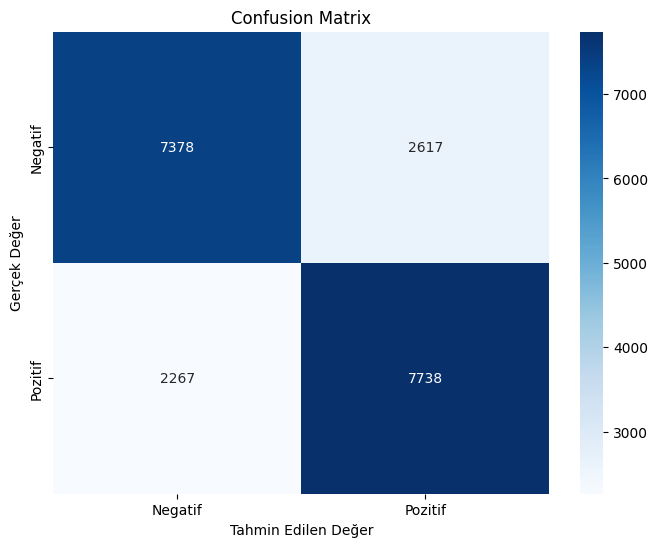

In [9]:
# Modelin Confusion Matrix'ini Görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'])
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.title('Confusion Matrix')
plt.show()

# Transformer Tabanlı Dil Modelleri

In [10]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# 1. Hugging Face Dataset formatına dönüştürme
train_data = Dataset.from_dict({"text": X_train.tolist(), "labels": y_train.tolist()})
test_data = Dataset.from_dict({"text": X_test.tolist(), "labels": y_test.tolist()})

# 2. Tokenizer ve Model Yükleme
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# 3. Tokenizasyon Fonksiyonu
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Veri tokenizasyonu
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# 4. Eğitim Argümanları
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none" 
)

# 5. Trainer Nesnesi Oluşturma
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        "f1": f1_score(p.label_ids, p.predictions.argmax(-1))
    }
)


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/2747386062.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# 6. Modeli Eğitme
trainer.train()

# 7. Değerlendirme
results = trainer.evaluate()
print("Test Set Sonuçları:", results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.456800,0.462023,0.784050,0.781217


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Test Set Sonuçları: {'eval_loss': 0.46202322840690613, 'eval_accuracy': 0.78405, 'eval_f1': 0.7812167570031912, 'eval_runtime': 165.0142, 'eval_samples_per_second': 121.202, 'eval_steps_per_second': 1.897, 'epoch': 1.0}


In [13]:

# Cihazı belirleyin (CUDA varsa GPU, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli cihazda çalıştırılacak şekilde ayarlayın
model.to(device)

# 8. Örnek Tahmin
test_sentences = ["I love this product!", "This is the worst experience ever."]
inputs = tokenizer(test_sentences, return_tensors="pt", padding=True, truncation=True)

# Verileri aynı cihaza gönderin
inputs = {key: value.to(device) for key, value in inputs.items()}

# Modeli cihazda çalıştırmak
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=1)
print("Tahminler:", predictions.tolist())


Tahminler: [1, 0]


# Sonuçları Karşılaştırma

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Model Performans Karşılaştırması:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression   0.75580   0.747272  0.773413  0.760118
1                 BERT   0.78405   0.792009  0.770715  0.781217


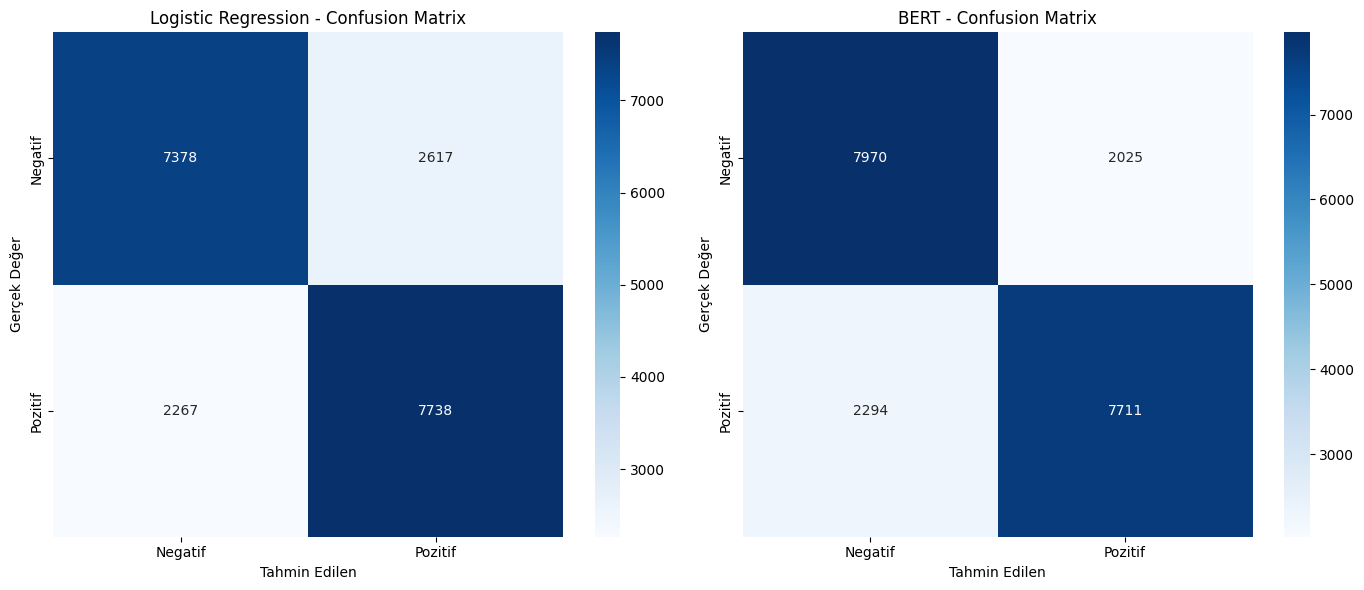

In [14]:
# TF-IDF + Logistic Regression Modeli
# Modelin performansını değerlendir
logreg_accuracy = accuracy
logreg_precision = precision
logreg_recall = recall
logreg_f1 = f1

# TF-IDF + Logistic Regression için confusion matrix
logreg_conf_matrix = confusion_matrix(y_test, y_pred)

# BERT Modeli için performans metriklerini alalım
trainer_results = results  # Hugging Face Trainer'ın değerlendirme sonuçları
bert_accuracy = trainer_results["eval_accuracy"]
bert_f1 = trainer_results["eval_f1"]

# BERT modelinin confusion matrix'ini almak için tahminleri yapalım
# BERT modeline test verilerini tahmin ettirelim
bert_preds = trainer.predict(test_data).predictions.argmax(-1)

# BERT modelinin confusion matrix
bert_conf_matrix = confusion_matrix(y_test, bert_preds)

# Performans Metriklerini Görselleştirme
metrics = pd.DataFrame({
    "Model": ["Logistic Regression", "BERT"],
    "Accuracy": [logreg_accuracy, bert_accuracy],
    "Precision": [logreg_precision, precision_score(y_test, bert_preds)],
    "Recall": [logreg_recall, recall_score(y_test, bert_preds)],
    "F1-Score": [logreg_f1, bert_f1]
})

print("Model Performans Karşılaştırması:")
print(metrics)

# Confusion Matrix Görselleştirmesi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(logreg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'], ax=axes[0])
axes[0].set_title("Logistic Regression - Confusion Matrix")
axes[0].set_xlabel("Tahmin Edilen")
axes[0].set_ylabel("Gerçek Değer")

# BERT Confusion Matrix
sns.heatmap(bert_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'], ax=axes[1])
axes[1].set_title("BERT - Confusion Matrix")
axes[1].set_xlabel("Tahmin Edilen")
axes[1].set_ylabel("Gerçek Değer")

plt.tight_layout()
plt.show()


# Özet Çıkarımı

In [15]:
import random
from transformers import T5Tokenizer, T5ForConditionalGeneration

# 1. Veri setinden rastgele 20 metin seçme
sampled_texts = random.sample(df['text'].tolist(), 20)

# 2. Özetleme işlemi için T5 modelini yükleyelim
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to("cuda")

# Metin özetleme fonksiyonu
def summarize_texts(texts, max_length=25, min_length=5):
    input_texts = ["summarize: " + text for text in texts]

    # Girdileri tokenize et
    inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    
    # Model ile özet oluştur
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    ).to("cuda")

    # Özetleri çöz ve döndür
    summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

    # Eğer özet uzunluğu orijinal metinden uzun olursa orijinal metni döndürüyoruz
    for i in range(len(texts)):
        text = texts[i]
        summary = summaries[i]
        if len(text) < len(summary):
            summaries[i] = text

    return summaries

# 3. Rastgele seçilen metinleri özetleyelim
summarized_texts = summarize_texts(sampled_texts)

# 4. Sonuçları ekrana yazdıralım
for i, (original_text, summarized_text) in enumerate(zip(sampled_texts, summarized_texts)):
    print(f"Original Text {i+1}: {original_text}\n")
    print(f"Summarized Text {i+1}: {summarized_text}\n\n")

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Original Text 1: cancel son robot gig tonight luke state perform night attack dishearten

Summarized Text 1: cancel son robot gig tonight luke state perform night attack dishearten


Original Text 2: everyone call I m sleep

Summarized Text 2: everyone call I m sleep


Original Text 3: yes miss jon wish

Summarized Text 3: yes miss jon wish


Original Text 4: wish could eat I m even drink tonight

Summarized Text 4: wish could eat I m even drink tonight


Original Text 5: ah would babysit day car flat tire

Summarized Text 5: ah would babysit day car flat tire


Original Text 6: wish iphone

Summarized Text 6: wish iphone


Original Text 7: I m missin school todayand realize much fun

Summarized Text 7: I m missin school todayand realize much fun


Original Text 8: give rename quotbloody scannerquot time cook dinner instead

Summarized Text 8: give rename quotbloody scannerquot time cook dinner instead


Original Text 9: hhait rain ill buy itune

Summarized Text 9: hhait rain ill buy i